# Mamography Smart Fit

<div style="font-size:18px"> Among all types of radiologic exams, few can match the sheer speed of mamography annalysis. The whole proccess takes  few seconds and every  second the radiologist takes preparing the images, repositioning and zooming takes a heavy toll on its productivity!

<br><p> The system needs to zoom and  pan the image so that only relevant tissue it shown in the screen. 

For that to happen we need to discover the bounding box around the breast 

<div style="font-size:18px"> <font color='orange'> Let's start with some utility code, import libraries and etc... This is unrelated to the problem.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pydicom
import itk
import cv2
import numpy as np

In [18]:
#Lets load some files!
#input_image = pydicom.read_file("/mnt/storage/Evidences/najara_issues/imagem.dcm")
input_image = pydicom.read_file("/mnt/storage/Evidences/najara_issues/imagem1.dcm")
#input_image = pydicom.read_file("/mnt/storage/Evidences/najara_issues/imagem2.dcm")
#input_image = pydicom.read_file("/mnt/storage/Evidences/najara_issues/imagem3.dcm")
#input_image = pydicom.read_file("/mnt/storage/Evidences/najara_issues/imagem4.dcm")
plt.imshow(input_image.pixel_array)
plt.show()

<div style="font-size:18px"> We can see in the above image that the mamography does not contain only breasts.. it also contains floating artifacts and a slice of the armpit tissue. 

<br>Those are wasted space and must not be taken into account when the system decide the minimal bounding box around the breast!

In [19]:
#lets start by rescaling the image into  smaller size
#This is usefull so we reduce the complexity of the problem  by treating the images as smaller  
#images

def quarterize_image(image):
    res = cv2.resize(image, dsize=(image.shape[1]//4, image.shape[0]//4), interpolation=cv2.INTER_CUBIC)
    return res

def quadruplicate_image(image):
    res = cv2.resize(image,dsize=(image.shape[1]*4, image.shape[0]*4), interpolation=cv2.INTER_CUBIC)
    return res

reduced_image= quarterize_image(input_image.pixel_array)
pixel_array = reduced_image.copy()

plt.imshow(pixel_array)
plt.show()

<div style="font-size:18px"> <br><font color='blue'>The very first step in most problems of image processing is to  define what is part of foreground and what is part of background of the image.  </font>

<br>That is usually  done by a miriad of different algorithms and results in a binary image. Here we will use the simplest of all forms.. the thresholding.

<br>We will make every pixel above a certain value to be ON and all other to be OFF. 

<br>But... what value shall we use? As a starting crude guess we will use the average value in the image

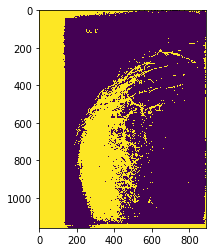

In [20]:
#lets binarize the image around the average value. Everything over that value will 
#be set to 1 and the rest to zero.
average_value = np.sum(pixel_array)/(pixel_array.shape[0]*pixel_array.shape[1])
t_image = np.array([1 if x > average_value else 0  for x in pixel_array.flat])
t_image = t_image.astype(np.uint8).reshape(pixel_array.shape)

#the results
plt.imshow(t_image)
plt.show()

<div style="font-size:18px"> As we can observe, the quick and dirty estimation of the thresholding is not good enough and  can miss parts of the breast. 

<br>We need to improve the thresholding....  

<br>We could try to compute a thresholding value directly, but for that we would need to  study and develop a model  capable of predicting such a value.

<br>As is common in  scientific computing we can  simply search the best value until we  are  satisfied.

<br><font color='blue'>We also have the problem of  floating  artifacts in the image. The nomenclature markings on the  mamography  should not be taken into account when finding the bounding box of the breast. We need also to remove those from the image...  </font>

<br>We have a lot of problems to solve!

<div style="font-size:18px"> <font color='orange'> WE NEED  MORE  INFORMATION ON THE BREAST!</font> 

<br><font color='blue'>We need to better identify what is and what is not part of the breast! </font>

<br> We want to find the shape of the breast.. but how?

<div style="font-size:18px"> <font color ='blue'>  </font>
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.
<br>.

<br><font color='dark red'> 

<br>1. Find something that is part of the breast 
<br>2. The rest of breast should be connected to it...


</font>

For that we will need to make an educated assumption!

<br>The base of the breast is connected to the border of the image and
we can reasonably expect the middle height of the image at that border to be part of the breast!

That means we need to find that point and follow it to define what is and what is not part of the breast. But.. how we do it?


<br><font color='blue'> The first thing we need to find the base of the breast. That means.. to find out if the breast is aligned to the left or right side of the image. </font>

<br>Does anyone has any guesses about how we do it?

In [49]:
#Uncomment this when you are ready for the 
#true power of this fully operational code!
pixel_array =  clean_image.copy()

<div style="font-size:18px"> One approach to discover alignment of an image is to compare the right side and the left side of the image as separate entities ...  The logical first step to do so is to split the image in 2 halves...

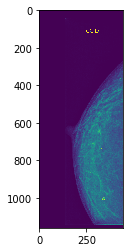

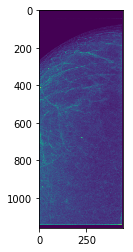

In [50]:
#simple method that returns 2 images where once there was one
def split_image_left_and_right(pixel_array):    
    h,w = pixel_array.shape
    return  pixel_array[:h,:int(w/2)],pixel_array[:h,int(w/2):]

pixel_count = pixel_array.shape[0] * pixel_array.shape[1]
ll,rr = split_image_left_and_right(pixel_array) # now we will have the left and right halves of image

#let's check the results
plt.imshow(ll)
plt.show()
plt.imshow(rr)

<div style="font-size:18px"> Now we need to infer useful things about these 2 slices. 

<br>As can be observed, there is on average more information on the lines of the image where the breast is  aligned to the wall of the image. We can take this as the heuristics on how we will decide upon the image alignment.

In [51]:
#count the value of pixels in each image. 
left_count = np.sum(ll)
right_count = np.sum(rr)

#The image with most combined value is likely the one with more 
#information.. and therefore as we previously  decided.. the likely  
#wall alignment side

#Normalize it to an average
mean_at_right = (2*right_count)  / pixel_count
mean_at_left = (2*left_count)/ pixel_count

#we will use this value to infer what is and what is not part of the breast
threshold_count  = int((mean_at_left + mean_at_right)/2)

#if there is more info on the left size then the right size then ...
breast_is_left_side = mean_at_left > mean_at_right


breast_is_left_side

False

<div style="font-size:18px">Ok! Now we know if the image is aligned to the left or to the right! 

<br>From here now we just need to follow that point to the border of the breast.. that is easy!.. isn't it?

<br>Unfortunately the correct answer is both yes and no. There are literally  dozens of algorithms that do that. Flood filling, Watershedding, Fast Marching.  All too complex to explain in a short tech talk. That said we can use the simplest form .. the Region Growing Algorithm

<br>The Region Growing algorithm expands a point in an image
growing into any region that stays within a specific condition or range of the original point and it is connected to the original point directly or by means of other points previously marked by the algorithm.

In [23]:
#we want to find the earliest column in the image where the row r is not
#zero
def leftmost_non_zero(im,r):
    for a in range (0,im.shape[1]):
        if im[r][a] != 0:
            return a
    return im.shape[1]

#we want to find the last column in the image where the row r is not
#zero
def rightmost_non_zero(im,r):
    for a in reversed(range(0, im.shape[1])):
        if im[r][a] != 0:
            return a
    return 0

#this classic... and a bit outdated method expands a point in an image
#growing into any region that stays within a specific condition or range of the 
#original point and it is connected to the original point directly or
#by means of other points previously marked in the map
def region_growing(image, breast_is_left,fill_val, check_val):
    half_height = image.shape[0]//2
    
    initial_row = half_height
    initial_column = leftmost_non_zero(image,initial_row) if breast_is_left else rightmost_non_zero(image, initial_row)
    initial_value = image[initial_row, initial_column]
    
    #this is in theory a recursive algorithm. As most non theorical computer
    #scientists know..  recursive is BAD... very bad! So we convert it to a 
    #stack based implementation
    
    #we start the stack with the initial point and later will add its neighbors
    #that pass the test
    points_col =[initial_column]
    points_row =[initial_row]
    
    control_map = np.zeros(image.shape)
    while (len(points_col) > 0) and (len(points_row) >0):
        r = points_row.pop()
        c = points_col.pop()
        control_map[r][c] = fill_val
        ru = r+1
        rd = r-1
        cr = c+1
        cl = c-1
        #only take into account neighbors that do not spill out of
        #the image... then fill it in the map and append it as a seed
        #for the next cycle        
        if rd >0 :
            if (control_map[rd][c] == 0) and(image[rd][c]==check_val):
                points_row.append(rd)
                points_col.append(c)
                control_map[rd][c]=fill_val
        if cr < image.shape[1]:
            if (control_map[r][cr] == 0) and(image[r][cr]==check_val):
                points_row.append(r)
                points_col.append(cr)
                control_map[r][cr]=fill_val
        if ru < image.shape[0]:
            if (control_map[ru][c] == 0) and(image[ru][c]==check_val):
                points_row.append(ru)
                points_col.append(c)
                control_map[ru][c]=fill_val
        if cl > 0:
            if (control_map[r][cl] == 0) and(image[r][cl]==check_val):
                points_row.append(r)
                points_col.append(cl)
                control_map[r][cl]=fill_val
    return control_map

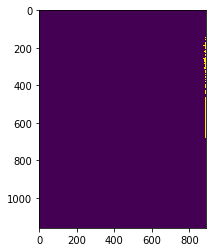

In [52]:
control_result = region_growing(t_image,breast_is_left_side, 255,1)
plt.imshow(control_result)

The region  growing got rid of floating artifacts, but it also drops small segments of the breast that are not  fully connected to the central mass.

<br>To get a better result we need a better thresholding value for our binarization  .. before we do the region growing!

<br>We will now present a method of optimization to find what thresholding value is good enough for our objective.

<br>The algorithm repeatedly binarize the image with a threshold value. That threshold value then feeds a region growing algortithm. The resulting map then is annalyzed in a histogram of bins of adjacent rows. The variation from bin to bin is then analyzed and compared to the expected behavior of an histogram applied to a perfectly segmented breast.

<br>The histogram of a perfectly segmented breast behaves roughly as 2 monotonic curves that meet at the height of the image where the nipple is located. If the segmented histogram deviates too much of that means the segmentation is either fragmented or it still contains  elements that do not pertain to the breast.

<br> If the histogram deviates too much then then threshold is not agressive enough and the proccess is repeated with an adjusted value.


In [9]:
from matplotlib.pyplot import figure

In [13]:
#this method makes a presumption that breasts are (at least when in a mamography
# exam) like sidesway bell shaped and the histograms of the rows will have
#roughly monothonic growth from the borders into the center.. roughly
#we want to find how much the pattern deviates from that concept. THe more 
#deviation we observe, in theory, means our image is either taking into account
# more than breasts (like the armpit) or the thresholding is creating a shape too
#irregular
def histogram_variation(hist):
    variance_bins =np.zeros(len(hist)//5 +1)
    #find max value  index on histogram
    max_index = np.argmax(hist)
    for i in range(0,max_index):
        if hist[i +1] < hist[i]:
            variance_bins[i//5] +=1
            
    for i in range(max_index, len(hist)-1):
        if hist[i +1] > hist[i]:
            variance_bins[i//5] +=1
            
    bins_larger_than_zero = sum([1 if x >0 else 0 for x in variance_bins])    
    return (bins_larger_than_zero /(len(hist)-1))*100   


#This is the method that will search for a good threshold value
def search_best_histogram(p_array, initial_thold,breast_left):
    T = initial_thold
    
    min_variation = 1000 # since this is a percentage based search .. we init over the limit
    #we will push the threshold down until we find the minimally acceptable one
    min_t_hold = initial_thold
    #the dimentions of the image shortcuted to smaller identifiers
    h,w = pixel_array.shape[:2]
    
    
    while True: # while not satisfied
        #Binarize with the current threshold value
        t_image = np.array([1 if x > T else 0 for x in pixel_array.flat])
        t_image = t_image.astype(np.uint8).reshape(pixel_array.shape)
       
        #try to find the breast shape using the strategy  previously defined
        mask =region_growing(t_image,breast_is_left_side,255,1)
                       
        #create a histogram by rows of the  mask
        row_histogram = [ np.sum(mask[x,:])for x in range(0,h)]
        
        ########UNCOMMENT FOR EXPLANATION
        #figure(num=None, figsize=(10,10), dpi = 100, facecolor='w', edgecolor='k')
        #figure(figsize=(5,5))
        #plt.bar(range(len(row_histogram)), row_histogram, align='center')        
        #plt.show()       
        #return
        ########
        
        #obtain the rate of missmatch of the histogram to the "normal" shape
        variation_on_rows = histogram_variation(row_histogram)
        
        #if the presented variation is better then the previous one
        #we take it as the new best variation (and accompaning threshold that
        #generated it)
        if variation_on_rows < min_variation:
            min_variation = variation_on_rows
            min_t_hold = T
        
        #the exit conditions are either thre threshold gettign too small ( a threshold
        # of 1 means  all image will be blank) or the variation getting small enough
        if (T <2) or (variation_on_rows < 15) :          
            plt.imshow(mask)
            plt.show()
            return T       
        else:
            T = T // 2

Lets see what our code finds as a good thresholding value..
               

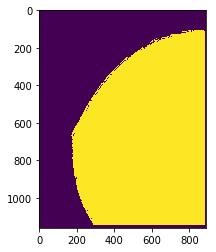

In [53]:

best_histogram_thold =search_best_histogram(pixel_array,threshold_count,breast_is_left_side)

In [15]:
#this code could be improved... but it is less interesting than 
# the rest of the content we have for this tech talk so we will use
# a "search forthe smallest histogram value" approach on both columns 
#and rows
def breast_bounding_box(image, threshold, breast_left): 
    h,w = pixel_array.shape[:2]
    t_image = np.array([1 if x > threshold else 0 for x in pixel_array.flat])
    t_image = t_image.astype(np.uint8).reshape(pixel_array.shape)
    mask =region_growing(t_image,breast_is_left_side,1,1)
    row_histogram = [np.sum(mask[x,:])for x in range(0,h)]
    col_histogram = [np.sum(mask[:,-(x+1)]) for x in range (1,w)]
    col_histogram.reverse()                            
    small =1000000
    smalli=0
    infcol=0
    supcol=len(col_histogram)-1
    min_col = len(row_histogram)*0.05
    if breast_left == False:
        for i in range (0,len(col_histogram)):
            if (col_histogram[i]) <= small and (col_histogram[i] > min_col):
                smalli =i;
                small= col_histogram[i]
        infcol =smalli
    else:
        for i in range (0,len(col_histogram)):
            if (col_histogram[i]) < small and (col_histogram[i] > min_col):
                smalli =i;
                small= col_histogram[i]
        infcol =0
        supcol=smalli
    small = 1000000            
    half_h = len(row_histogram)//2
    for i in reversed(range(0,half_h)):
        if row_histogram[i] < small:
            small = row_histogram[i]
            smalli = i
        infrow = smalli
    small = 1000000
    for i in range(half_h,len(row_histogram)):
        if row_histogram[i] < small:
            small = row_histogram[i]
            smalli = i
        suprow = smalli
    return infcol, supcol, infrow, suprow
        
                
    
                            
                            

In [54]:
a,b,c,d = breast_bounding_box(pixel_array,best_histogram_thold,breast_is_left_side)


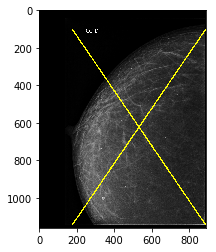

In [55]:
colored = cv2.cvtColor(pixel_array,cv2.COLOR_GRAY2BGR)  
cv2.line(colored,(a,c),(b,d),(255,255,0),5)
cv2.line(colored,(a,d),(b,c),(255,255,0),5)
plt.imshow(colored, interpolation='nearest')
plt.show()


Success!!! Or not.. depending on what image you used in this example. The bounding box defined by the crossing lines might not be where we expected! How do we solve that?

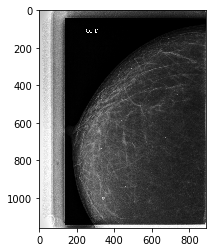

In [28]:
reduced_image = quarterize_image(input_image.pixel_array)
plt.imshow(reduced_image, interpolation='nearest', cmap='gray')
plt.show()

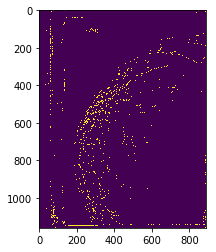

In [29]:
edges = cv2.Canny(np.uint8(reduced_image),100,150,apertureSize = 3)
plt.imshow(edges,interpolation='nearest')


In [30]:
def hough_transform(binary_image,min_a, max_a, steps_a, min_b, max_b, steps_b):
    ballot = np.zeros(steps_a*steps_b).reshape(steps_a,steps_b)
    tick_a = (max_a - min_a)/steps_a
    tick_b = (max_b - min_b)/steps_b
    
    for x in range(0,binary_image.shape[1]):
        for y in range(0,binary_image.shape[0]):
            val = binary_image[y][x]
            if val > 0:
                for a in range(0,steps_a):
                    for b in range(0,steps_b):
                        real_a = min_a + tick_a*a
                        real_b = min_b + tick_b*b
                        if (abs(real_a *x + real_b -y) < 1):
                            ballot[a][b]+=1
    voting_results=[]
    for a in range(0,steps_a):
        for b in range(0,steps_b):
            voting_results.append((min_a + tick_a*a,min_b + tick_b*b,ballot[a][b]))
    return voting_results    
                

This is a handmade classic Hough Transform, and it works. One can test and assure himself of that in the following cell where 2 artificial lines are detected.

CPU times: user 9.57 s, sys: 0 ns, total: 9.57 s
Wall time: 9.57 s


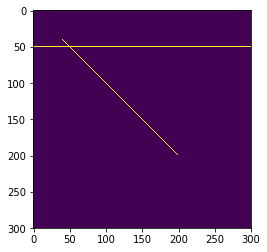

In [31]:
tiny_image = np.zeros(300*300).reshape(300,300)
for x in range(0,300):
    tiny_image[50][x] =255
for x in range(40,200):
    tiny_image[x][x] =255    
plt.imshow(tiny_image)
%time hough_results2 = hough_transform(tiny_image,0,3.1415/2,180,0,tiny_image.shape[0],tiny_image.shape[0])
sorted_hough2 = sorted(hough_results2, key=lambda x: x[2])
sorted_hough2.reverse()

In [35]:
sorted_hough2[3]


(1.0035347222222222, 0.0, 161.0)

There are a few problems with this code. The first one is that it is slow. Hough transforms are  heavy on the workload... the fact that this implementation is in python does not help either.

The second issue is that it does not take into account local continuity of the line. That means that 30 points  tightly aligned in a small spacial spam may be considered to  be worth less than 31 points.. aligned over a line but spread over a huge spacial span.

A modern and more capable variant of Hough Transform would be beyond the scope of this  lesson and we will  skip some work  by using OpenCV implementation of Probablistic Continuous Hough Transform.

In [ ]:
#tiny_edges = quarterize_image(edges)
#%time hough_results = hough_transform(tiny_edges,0,3.1415/2,180,0,tiny_edges.shape[0],tiny_edges.shape[0])
#warning.. 7 minutes
#sorted_hough = sorted(hough_results, key=lambda x: x[2])
#sorted_hough.reverse()

In [36]:

#Hough transforms punch above Python's weight class so we will have
#to resort to using a C++ implementation from OpenCV

minLineLength = 200 #np.amin(reduced_image.shape)/2
maxLineGap = 40
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength,maxLineGap)

After we have detected lines, we can print them in the image just to visualize better what we have detected!

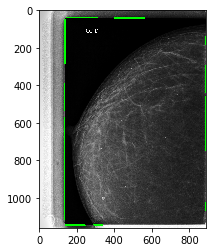

In [37]:
colored = cv2.cvtColor(reduced_image,cv2.COLOR_GRAY2BGR)
for x1,y1,x2,y2 in lines[:,0,:]:      
        cv2.line(colored,(x1,y1),(x2,y2),(0,255,0),5)
plt.imshow(colored, interpolation='nearest')
plt.show()

Ok , we are roughly satisfied with our line detection. We know what are the borders oft he frame around the image!

What we need to do now is to remove the areas outside this frame from our image.

Do you have an idea how can we do that?

.
.
.
.
.

The solution here proposed lies in the concept that it is easy to  find out if a point is in front or behind a line segment.

The trick lies on the fact that the projection of a point over a line that passes over the origin is positive if the point is in one side of the image and negative if it is in the other side! 

By adjusting the origin to a point where the line segment passes over we can apply the same logic.

In [39]:
class line_segment_in_image_alpha:
    
    def __init__(self,p1, p2,dimx,dimy):
        self.create(p1,p2)       
        self.define_image_center_projection(dimx,dimy)
        
    def create(self, v1, v2):
        self.v1=v1
        self.v2=v2               

    def projection(self, p1):
        #Define the orthogonal line to the segment defined by v1 and v2
        pte_normal = np.array([self.v1[1] - self.v2[1], 0 , self.v2[0] - self.v1[0]])
        #normalize the orthogonal (so we have thenormal of the line)
        normal = pte_normal / np.linalg.norm(pte_normal.astype(float))
        #adjust p1 to a local space relative to an origin over the point v1 of the segment
        vec1 = np.array([p1[0] - self.v1[0],0, p1[1] - self.v1[1]])
        #check the projection of the vector on the segment
        d1 = normal.dot(vec1.astype(float))
        return d1
    
    def define_image_center_projection(self, image_width, image_height):
        #define where the center of the image is...
        center = np.array([image_height/2,image_width/2])
        #define and record where the center lies relative to this segment
        self.center_proj = self.projection(center.astype(float))
        
    def same_side_as_image_center(self, p1):
        # if the point p1 is in the same side as the center... then..
        return  self.projection(p1) * self.center_proj > 0 

The above code works... you can skip this next cell and test it.. but it is slow. This is a good classic exercise on optimization. The segment is constant and independent to the points, therefore its normal does not need to be calculated every time we want to compare a point to the segment... With a little work we can  do a huge optimization.

In [42]:
class line_segment_in_image:
    
    #we omit the comments on this version to keep it short
    def __init__(self,p1, p2,dimx,dimy):
        self.create(p1,p2)       
        self.define_image_center_projection(dimx,dimy)
        
    def create(self, v1, v2):
        self.v1=v1        
        pte_normal = np.array([v1[1] - v2[1], 0 , v2[0] - v1[0]])
        self.normal= pte_normal // np.linalg.norm(pte_normal.astype(float))
        

    def projection(self, p1):
        vec1 = np.array([p1[0] - self.v1[0],0, p1[1] - self.v1[1]])
        d1 = self.normal.dot(vec1.astype(float))#.dot(self.normal)
        return d1
    
    def define_image_center_projection(self, image_width, image_height):
        center = np.array([image_height/2,image_width/2])
        self.center_proj = self.projection(center.astype(float))
        
    def same_side_as_image_center(self, p1):
        return  self.projection(p1) * self.center_proj > 0 

In [43]:
c_lines  = lines[:,0,:]
points = [[(P[0],P[1]),(P[2],P[3])] for P in c_lines]
#line_segments = [line_segment_in_image(V[0],V[1],reduced_image.shape[1],reduced_image.shape[0]) for V in points]
line_segments = [line_segment_in_image_alpha(V[0],V[1],reduced_image.shape[1],reduced_image.shape[0]) for V in points]

In [44]:
copy_of_image = reduced_image.copy()

def slow_clean(line_segments, copy_of_image):
    for x in range (0,reduced_image.shape[1]):
        for y in range (0,reduced_image.shape[0]):
            for segment in line_segments:
                if False == segment.same_side_as_image_center([x,y]):
                    copy_of_image[y,x]=0            
                    break
        
%time clean_image = slow_clean(line_segments,copy_of_image)

CPU times: user 3min 21s, sys: 48 ms, total: 3min 21s
Wall time: 3min 21s


In [45]:
plt.imshow(copy_of_image)
plt.show()

In [47]:
copy_of_image = reduced_image.copy()

def better_clean(line_segments, copy_of_image):
    half_width = int(reduced_image.shape[1]/2)
    for y in range(0, reduced_image.shape[0]):
        for x in range(0, half_width):
            abort_x = True
            for segment in line_segments:
                if False == segment.same_side_as_image_center([x,y]):
                        abort_x = False
                        copy_of_image[y,x]=0
                        break
            if abort_x :
                break;
        for x in reversed(range(half_width,reduced_image.shape[1])):
            abort_x = True                  
            for segment in line_segments:
                if False ==segment.same_side_as_image_center([x,y]):
                    abort_x = False
                    copy_of_image[y,x]=0
                    break                    
            if abort_x:                
                break
    return copy_of_image


%time clean_image = better_clean(line_segments, copy_of_image)

CPU times: user 8.73 s, sys: 92 ms, total: 8.82 s
Wall time: 8.74 s


In [48]:
plt.imshow(clean_image, interpolation='nearest')
plt.show()

In [ ]:
#enlarged = quadruplicate_image(copy_of_image)

#plt.imshow(enlarged, interpolation='nearest')
#plt.show()